In [189]:
import pandas as pd
import numpy as np

In [190]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import random

In [191]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.columns = df.columns.str.lower().str.replace(' ', '_')


In [192]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [193]:
df = df.drop(columns = ['default', 'loan'])
df.y = (df.y == 'yes').astype(int)

In [194]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [195]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']
    

In [172]:
categorical = ['job',          
    'marital',    
    'education',  
    'housing',   
    'contact',    
    'month', 
    'poutcome'
]    

numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Question 1

In [173]:
auc_scores = []
for feature in numerical :
    auc = roc_auc_score(y_train, df_train[feature])
    auc_scores.append(auc)
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    
    print(feature, auc)
    
numerical[auc_scores. index(max(auc_scores))] , max(auc_scores) 

age 0.512185717527344
balance 0.5888313805382317
day 0.525957882383908
duration 0.8147002759670778
campaign 0.5714543015682159
pdays 0.5901276247352144
previous 0.5985653242764153


('duration', 0.8147002759670778)

In [174]:
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown


In [175]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

# Question 2
- Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
- Compute AUC

In [176]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [177]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [178]:
auc = roc_auc_score(y_val, y_pred)
round(auc,3)

0.9

# Question 3: Precision and Recall
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them


In [179]:
from sklearn.metrics import precision_score, recall_score

In order to to find precision and recall, we have to convert the probability "y_pred" as binary vector using the threshold to decide if the client subscribed a term deposit or not.

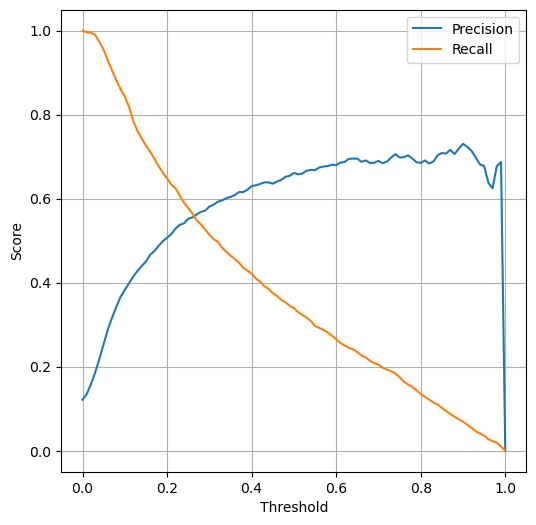

In [180]:
thresholds = np.arange(0.0, 1.01, 0.01)

precisions =[]
recalls = []

for t in thresholds : 

    y_decision = (y_pred >= t).astype(int)
    
    recall = recall_score(y_val, y_decision, zero_division = 0)
    precision = precision_score(y_val, y_decision, zero_division = 0)
    recalls.append(recall)
    precisions.append(precision)

plt.figure(figsize =(6,6))
plt.plot(thresholds, precisions, label = 'Precision')
plt.plot(thresholds, recalls, label = 'Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)  

# Question 4: F1 Score


In [181]:
F1s = []
for i in range(0, len(precisions)-1):
    F1 = 2*(precisions[i]*recalls[i])/(precisions[i]+recalls[i])
    F1s.append(F1)
    

In [182]:
thresholds[F1s. index(max(F1s))] , max(F1s) 

(0.22, 0.5728601252609603)

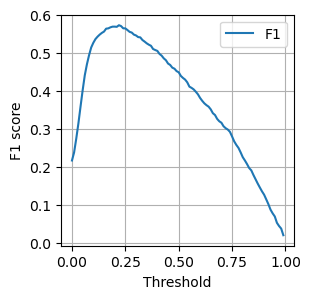

In [183]:
plt.figure(figsize =(3,3))
plt.plot(thresholds[:100], F1s, label = 'F1')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.grid(True)  

# Question 5 : 5 Fold CV

In [211]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train['y']
    del df_val['y']
    
    dv = DictVectorizer(sparse=False)

    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    
    val_dicts =df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    y_pred = model.predict_proba(X_val)[: ,1]
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(' %.3f +- %.3f' % ( np.mean(scores), np.std(scores)))


0it [00:00, ?it/s]

 0.906 +- 0.005


# Question 6

In [210]:

for c in [0.000001, 0.001, 1] : 
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        del df_train['y']
        del df_val['y']
        
        dv = DictVectorizer(sparse=False)
    
        train_dicts = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dicts)
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
    
        
        val_dicts =df_val.to_dict(orient='records')
        X_val = dv.transform(val_dicts)
        y_pred = model.predict_proba(X_val)[: ,1]
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


0it [00:00, ?it/s]

(1, 0.7014445869766514, 0.009444095099939862)


0it [00:00, ?it/s]

(1, 0.8610332873385191, 0.006803214851421645)


0it [00:00, ?it/s]

(1, 0.9056755190993779, 0.005322127966605898)
